# Grouped By Graph Type CNN Model With Contamination Using Scanpaths With 5x5 Kernel

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [ ]:
# Common settings
img_height = 288
img_width = 512
batch_size = 32

# Get the project root directory
# Try to find project root by looking for "Scanpaths" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Scanpaths" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Scanpaths")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Base dataset path: Scanpaths/organized_by_graph_type_contaminated (at project root)
base_dataset_path = os.path.join(project_root, "Scanpaths", "organized_by_graph_type_contaminated")

# Print path for verification
print(f"Project root: {project_root}")
print(f"Base dataset path: {base_dataset_path}")

In [4]:
# Function to create your original CNN model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(img_height, img_width, 1)),  # Grayscale input

        layers.Conv2D(32, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Train and evaluate one fold
def train_and_evaluate(dataset_name, fold, average_results):
    dataset_path = os.path.join(base_dataset_path, dataset_name)

    # Load datasets (RGB)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    # Convert RGB to grayscale
    def convert_to_grayscale(image, label):
        image = tf.image.rgb_to_grayscale(image)
        return image, label

    train_ds = train_ds.map(convert_to_grayscale)
    val_ds = val_ds.map(convert_to_grayscale)

    model = create_model()

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop]
    )

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} - Training vs Validation Accuracy - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Training vs Validation Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate on validation set
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Track final epoch accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    average_results["train_accuracies"].append(final_train_acc)
    average_results["val_accuracies"].append(final_val_acc)

    print(f"Fold {fold + 1} Final Train Acc: {final_train_acc:.4f}, Final Val Acc: {final_val_acc:.4f}")


=== Running 5-fold CV for: bar ===
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5557 - loss: 232.6291 - val_accuracy: 0.5484 - val_loss: 0.6927
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4500 - loss: 0.7768 - val_accuracy: 0.5548 - val_loss: 0.6930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5722 - loss: 0.6928 - val_accuracy: 0.5484 - val_loss: 0.6927
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6090 - loss: 0.6924 - val_accuracy: 0.5484 - val_loss: 0.6923
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5695 - loss: 0.6992 - val_accuracy: 0.5484 - val_loss: 0.6921


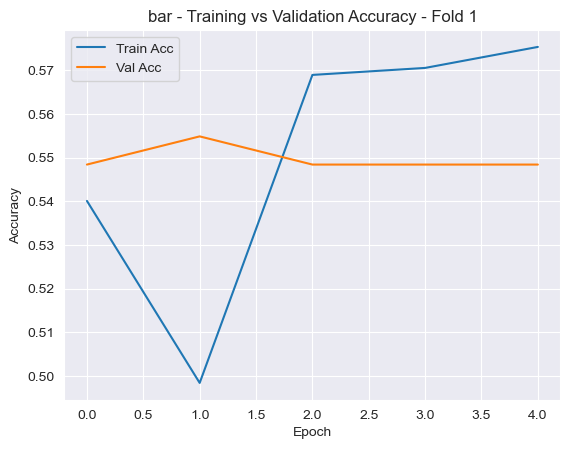

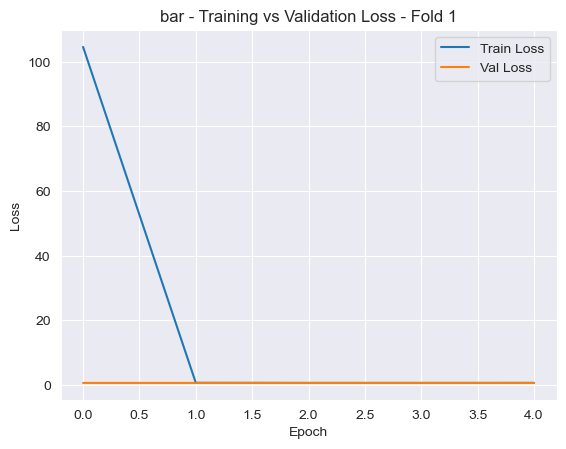

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


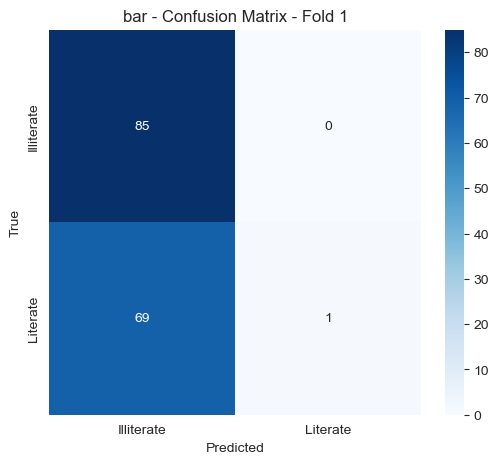

Fold 1 Final Train Acc: 0.5753, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5147 - loss: 453.6661 - val_accuracy: 0.5419 - val_loss: 0.6931
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5342 - loss: 0.7014 - val_accuracy: 0.5484 - val_loss: 0.6927
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5700 - loss: 0.6922 - val_accuracy: 0.5484 - val_loss: 0.6921
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6068 - loss: 0.6903 - val_accuracy: 0.5484 - val_loss: 0.6913
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5718 - loss: 0.6898 - val_accuracy: 0.5484 - val_loss: 0.6907


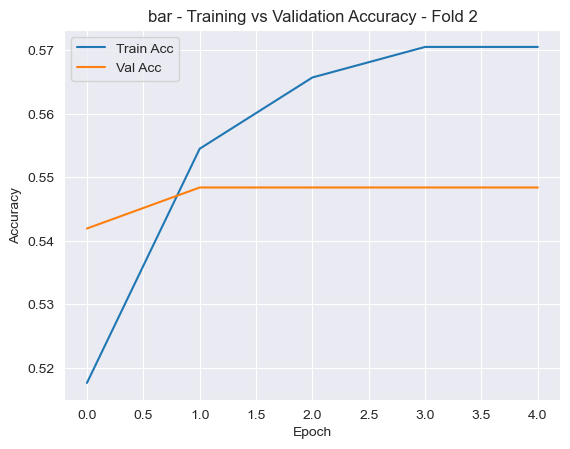

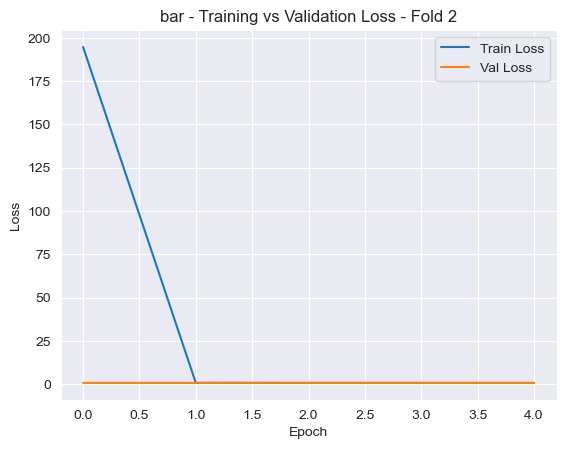

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


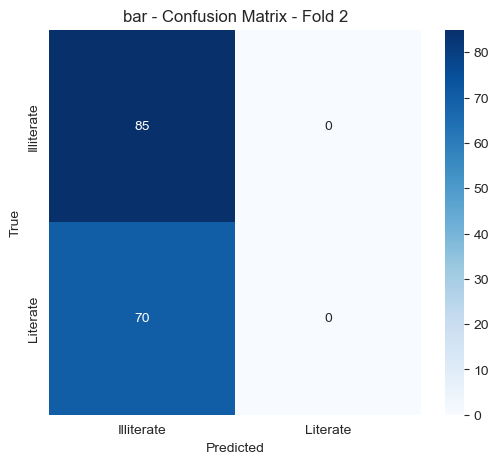

Fold 2 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5194 - loss: 515.2137 - val_accuracy: 0.5484 - val_loss: 8.8710
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4771 - loss: 4.0331 - val_accuracy: 0.5613 - val_loss: 0.6930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5861 - loss: 0.6889 - val_accuracy: 0.5419 - val_loss: 0.6922
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6148 - loss: 0.6780 - val_accuracy: 0.5419 - val_loss: 0.6929
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.6035 - loss: 0.6641 - val_accuracy: 0.5613 - val_loss: 0.6850


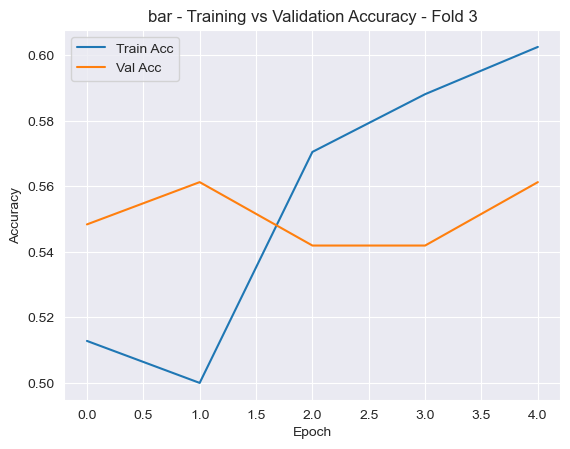

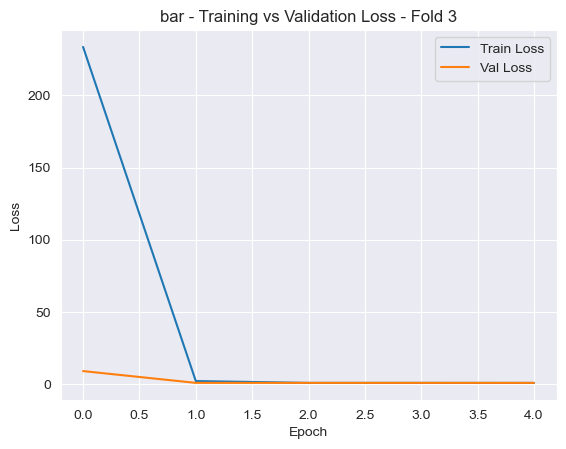

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


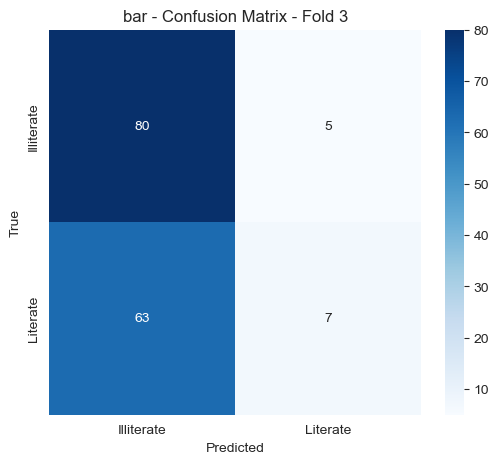

Fold 3 Final Train Acc: 0.6026, Final Val Acc: 0.5613
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4933 - loss: 350.6366 - val_accuracy: 0.5484 - val_loss: 0.6928
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5418 - loss: 0.8852 - val_accuracy: 0.5419 - val_loss: 0.6927
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5638 - loss: 0.6918 - val_accuracy: 0.5484 - val_loss: 0.6915
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6153 - loss: 0.6858 - val_accuracy: 0.5484 - val_loss: 0.6903


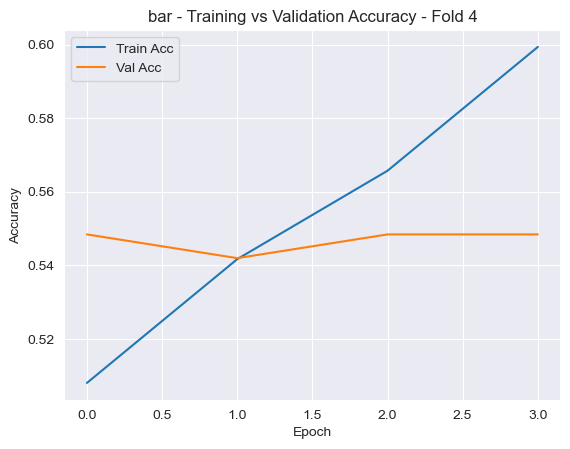

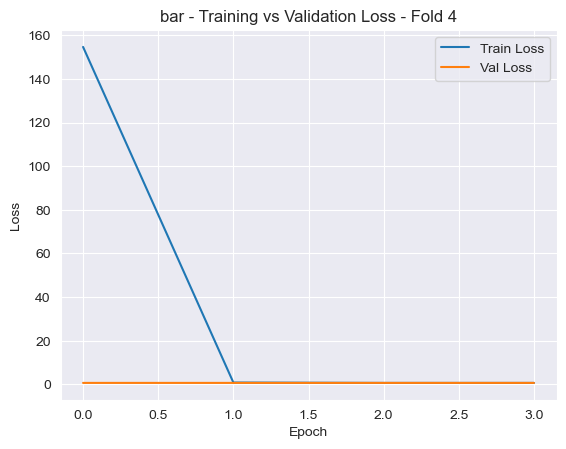

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


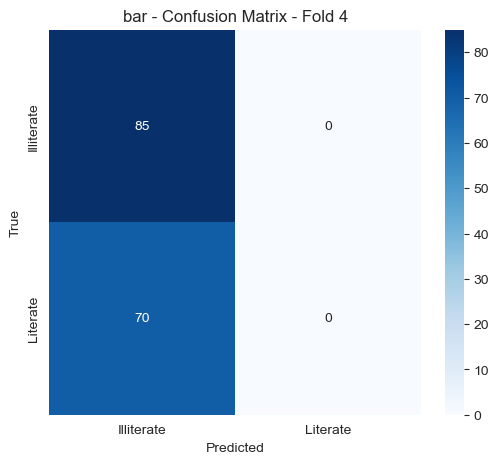

Fold 4 Final Train Acc: 0.5994, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4864 - loss: 433.8524 - val_accuracy: 0.5419 - val_loss: 0.6898
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5449 - loss: 0.6884 - val_accuracy: 0.5484 - val_loss: 0.6898
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5675 - loss: 1.0891 - val_accuracy: 0.5484 - val_loss: 0.6888
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6102 - loss: 0.6897 - val_accuracy: 0.5484 - val_loss: 0.6894
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.5718 - loss: 0.6857 - val_accuracy: 0.5484 - val_loss: 0.6885


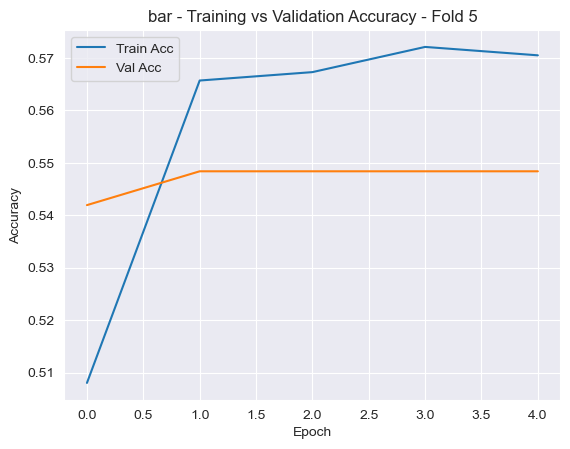

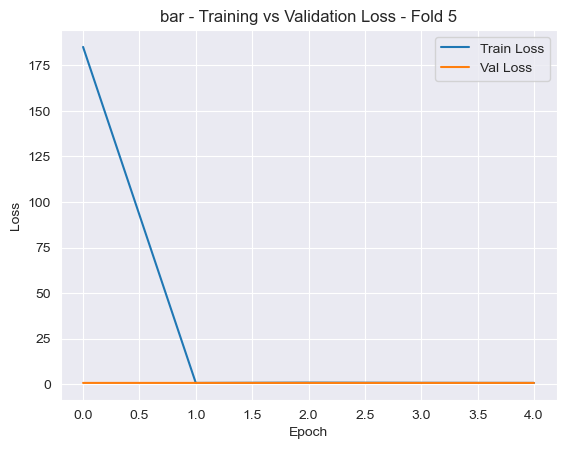

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


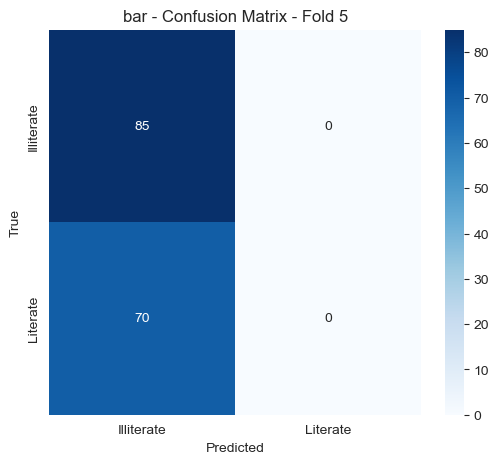

Fold 5 Final Train Acc: 0.5705, Final Val Acc: 0.5484

=== Running 5-fold CV for: line ===
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4554 - loss: 840.3953 - val_accuracy: 0.5614 - val_loss: 27.2921
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5017 - loss: 17.7382 - val_accuracy: 0.4123 - val_loss: 0.6983
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5785 - loss: 0.8020 - val_accuracy: 0.5614 - val_loss: 0.6930
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5540 - loss: 0.6929 - val_accuracy: 0.5614 - val_loss: 0.6927


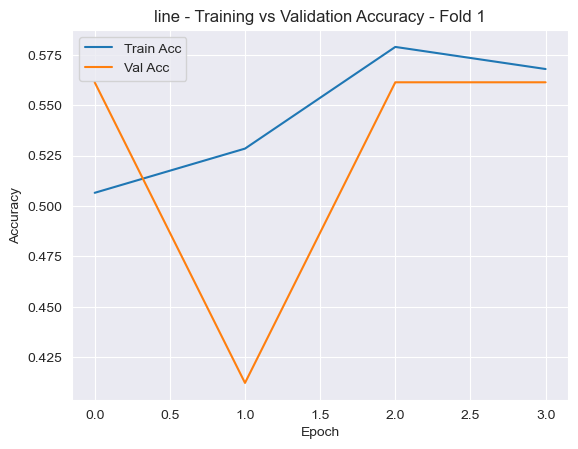

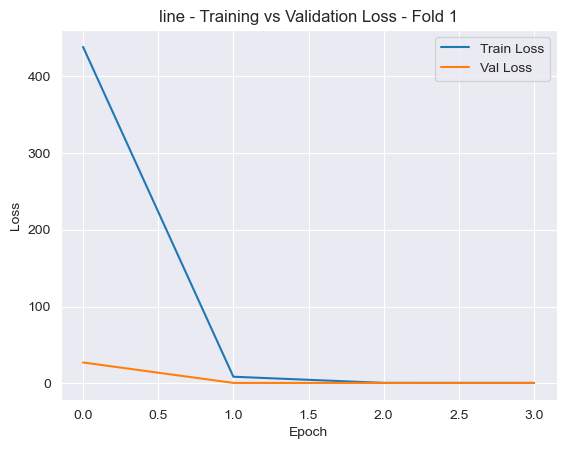

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


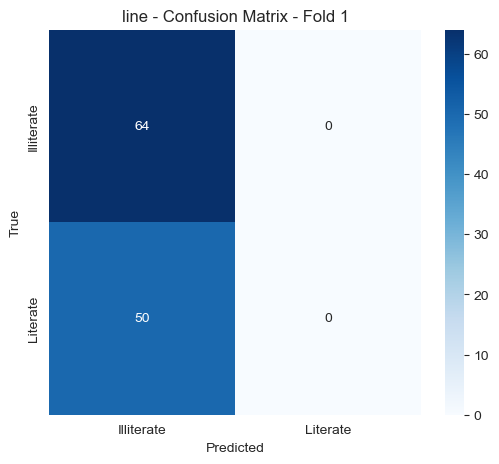

Fold 1 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5166 - loss: 519.3455 - val_accuracy: 0.4386 - val_loss: 0.8255
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5571 - loss: 1.1233 - val_accuracy: 0.6491 - val_loss: 0.6641
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6290 - loss: 0.6727 - val_accuracy: 0.6842 - val_loss: 0.5996
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6719 - loss: 0.6074 - val_accuracy: 0.7368 - val_loss: 0.5657
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7092 - loss: 0.5653 - val_accuracy: 0.7632 - val_loss: 0.5503
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7860 - loss: 0.5254 - val_accuracy: 0.7632 - val_loss: 0.5073
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/s

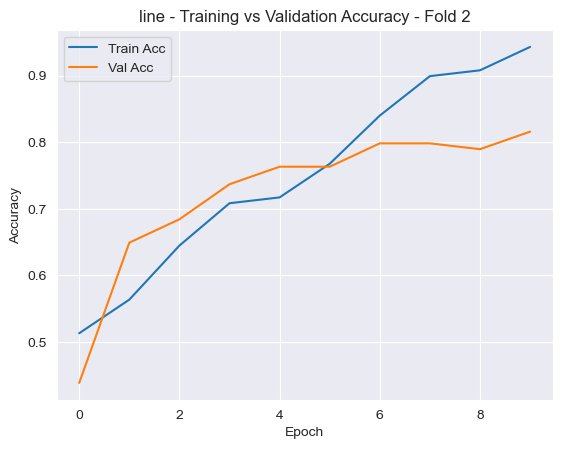

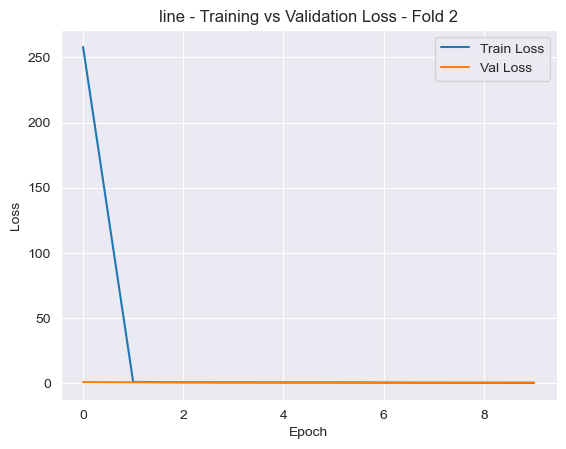

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


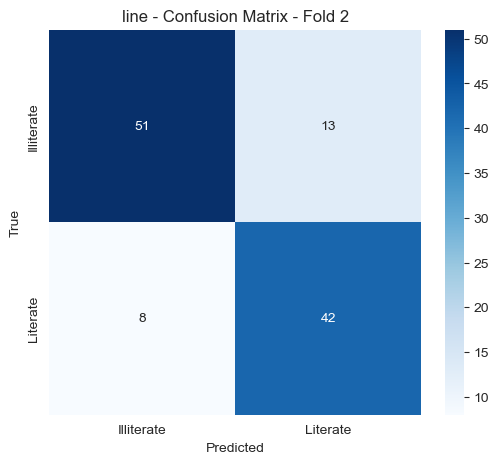

Fold 2 Final Train Acc: 0.9430, Final Val Acc: 0.8158
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.4523 - loss: 619.6667 - val_accuracy: 0.5614 - val_loss: 0.8089
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5502 - loss: 0.7752 - val_accuracy: 0.6842 - val_loss: 0.6759
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5168 - loss: 0.6778 - val_accuracy: 0.5614 - val_loss: 0.6376
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5540 - loss: 0.6263 - val_accuracy: 0.5614 - val_loss: 0.5977
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5872 - loss: 0.5712 - val_accuracy: 0.6754 - val_loss: 0.5751


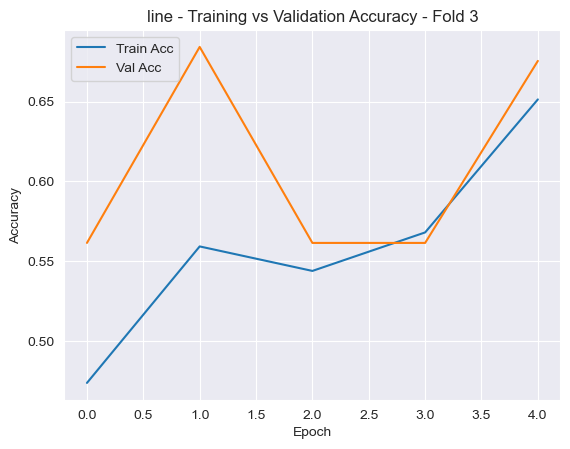

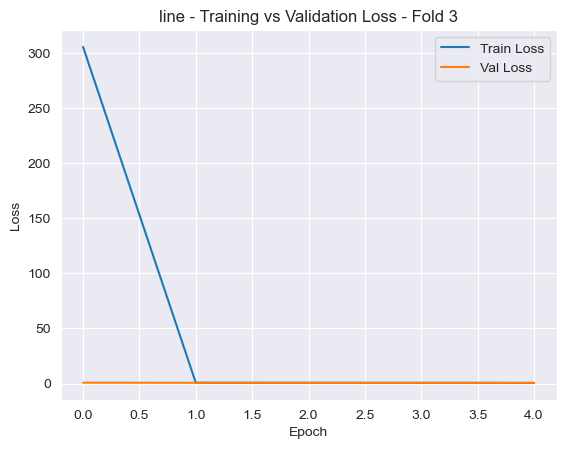

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


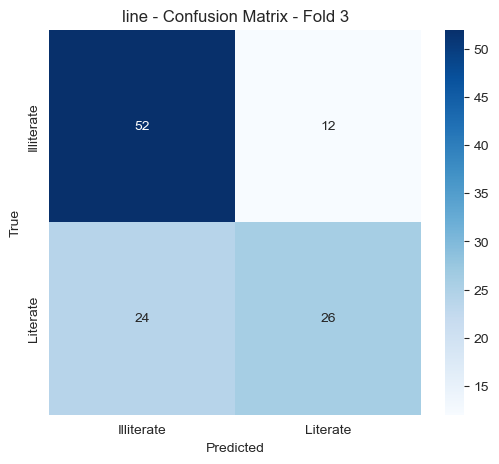

Fold 3 Final Train Acc: 0.6513, Final Val Acc: 0.6754
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5144 - loss: 979.2524 - val_accuracy: 0.4912 - val_loss: 0.6953
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5520 - loss: 0.6981 - val_accuracy: 0.6316 - val_loss: 0.6653
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6020 - loss: 0.6747 - val_accuracy: 0.5614 - val_loss: 0.6916
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5540 - loss: 0.6912 - val_accuracy: 0.5614 - val_loss: 0.6876
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5452 - loss: 0.6880 - val_accuracy: 0.5614 - val_loss: 0.6895


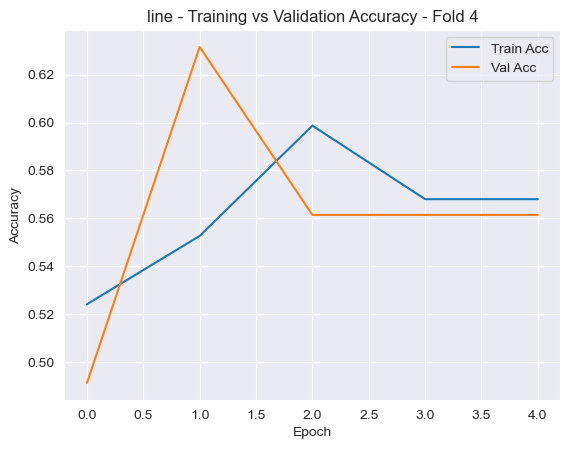

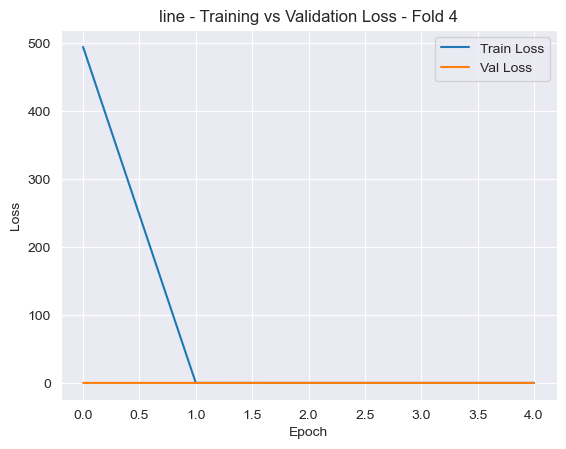

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


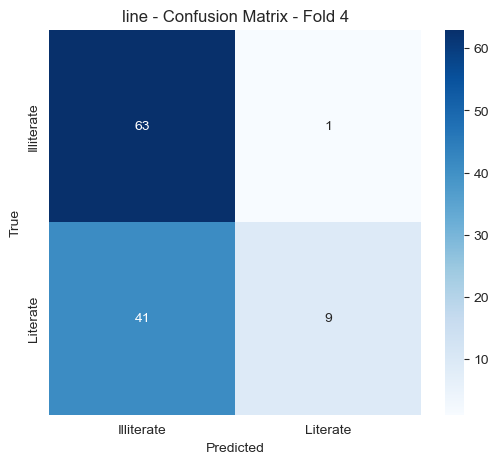

Fold 4 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4965 - loss: 1067.4838 - val_accuracy: 0.5439 - val_loss: 0.6937
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5579 - loss: 0.6942 - val_accuracy: 0.5614 - val_loss: 0.6924
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5483 - loss: 0.6924 - val_accuracy: 0.5614 - val_loss: 0.6916
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5540 - loss: 0.6914 - val_accuracy: 0.5614 - val_loss: 0.6906
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5452 - loss: 0.6910 - val_accuracy: 0.5614 - val_loss: 0.6896


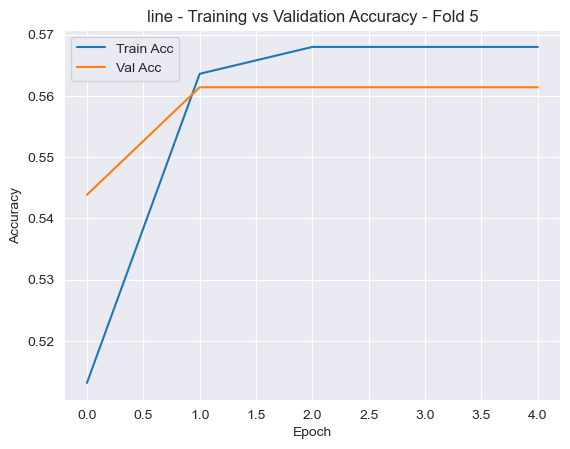

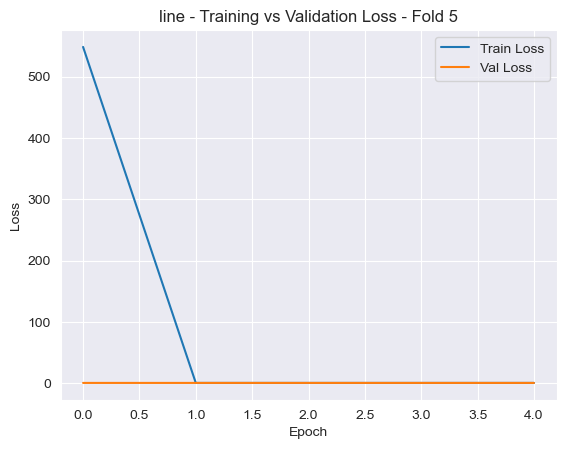

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


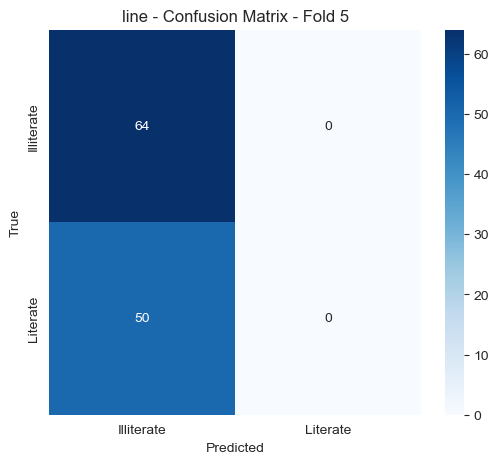

Fold 5 Final Train Acc: 0.5680, Final Val Acc: 0.5614

=== Running 5-fold CV for: pie ===
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5329 - loss: 407.7386 - val_accuracy: 0.6000 - val_loss: 8.5457
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5192 - loss: 7.6238 - val_accuracy: 0.6000 - val_loss: 2.9401
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3927 - loss: 3.6353 - val_accuracy: 0.6000 - val_loss: 0.6909
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.5640 - loss: 0.6921 - val_accuracy: 0.3667 - val_loss: 0.6965


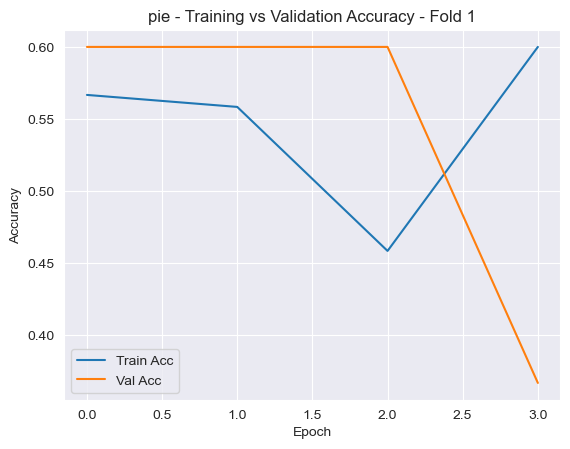

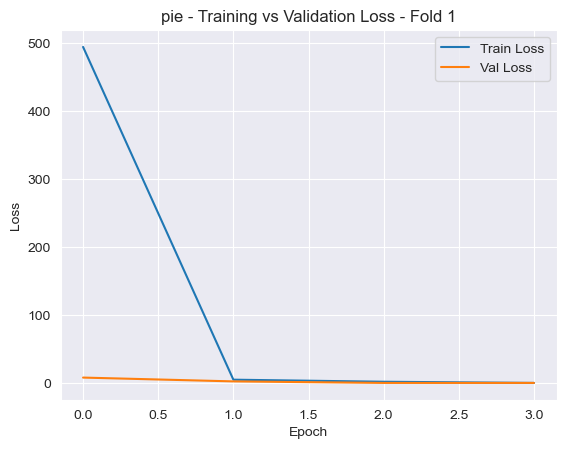

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


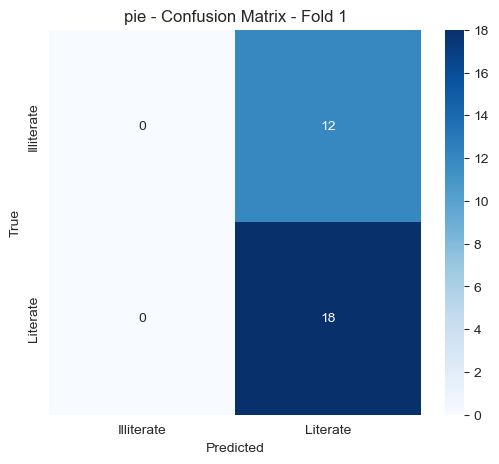

Fold 1 Final Train Acc: 0.6000, Final Val Acc: 0.3667
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.4619 - loss: 765.6982 - val_accuracy: 0.4000 - val_loss: 184.7676
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.5010 - loss: 87.3503 - val_accuracy: 0.4000 - val_loss: 8.4651
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.6215 - loss: 13.6846 - val_accuracy: 0.6000 - val_loss: 5.5039
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.4748 - loss: 9.8048 - val_accuracy: 0.4000 - val_loss: 0.8280
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.6258 - loss: 0.9542 - val_accuracy: 0.4000 - val_loss: 0.6982
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.6023 - loss: 0.7782 - val_accuracy: 0.6333 - val_loss: 0.6890
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accur

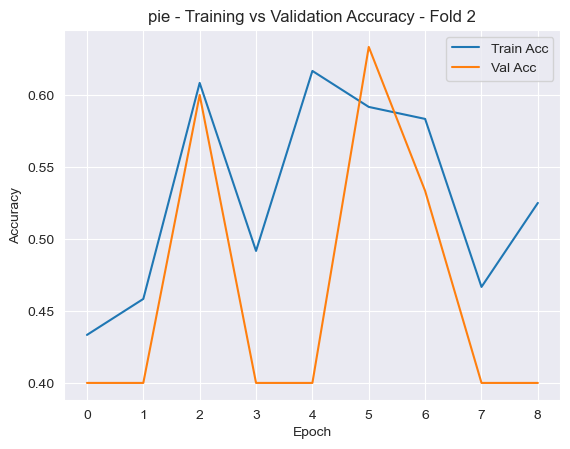

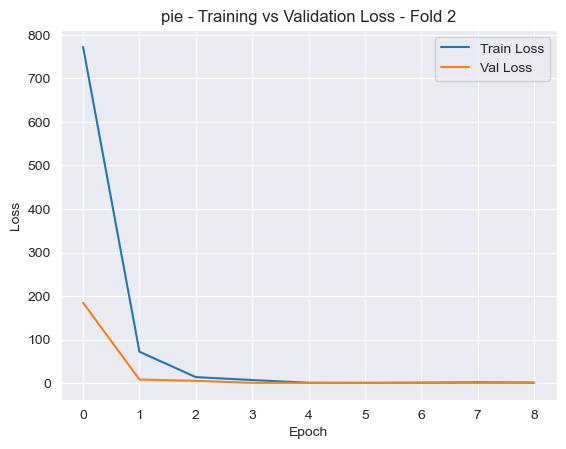

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


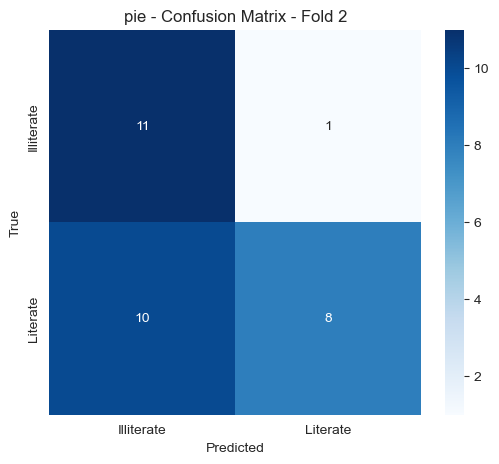

Fold 2 Final Train Acc: 0.5250, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.5625 - loss: 958.3680 - val_accuracy: 0.6000 - val_loss: 165.8067
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.4825 - loss: 113.3538 - val_accuracy: 0.6667 - val_loss: 0.8960
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.5379 - loss: 24.6941 - val_accuracy: 0.6000 - val_loss: 3.7204
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.6035 - loss: 9.7451 - val_accuracy: 0.6000 - val_loss: 0.6657
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4665 - loss: 2.8873 - val_accuracy: 0.4000 - val_loss: 1.1211


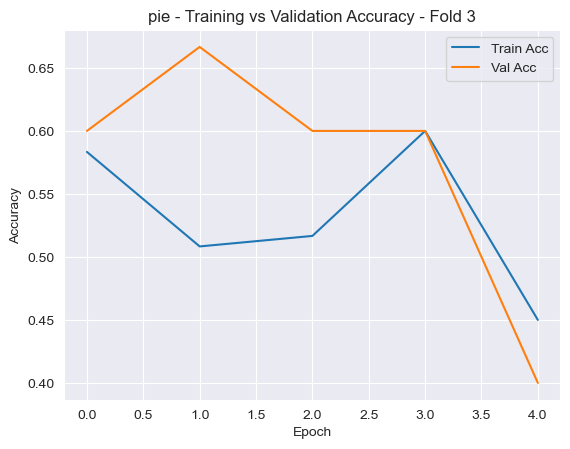

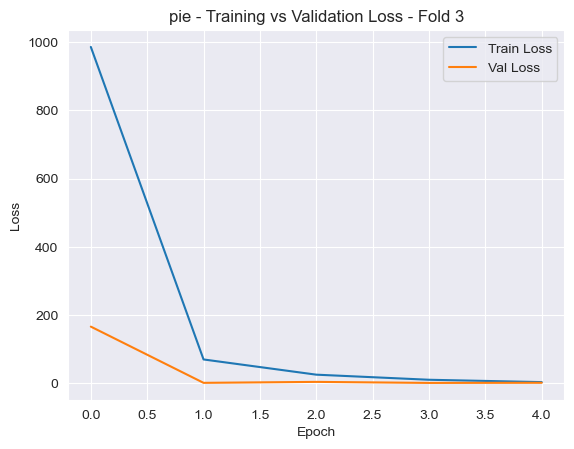

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


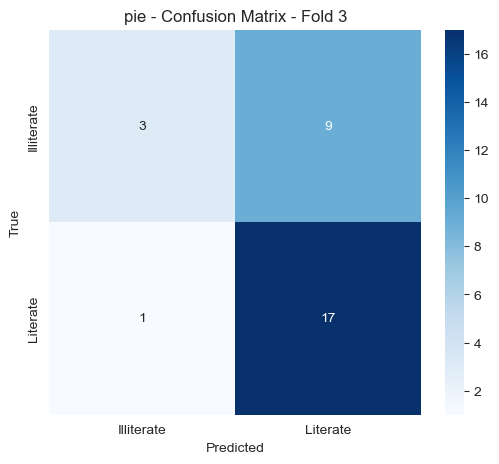

Fold 3 Final Train Acc: 0.4500, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.3931 - loss: 536.4738 - val_accuracy: 0.4000 - val_loss: 177.6864
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.5054 - loss: 73.2202 - val_accuracy: 0.4000 - val_loss: 2.7024
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.5558 - loss: 2.7360 - val_accuracy: 0.6000 - val_loss: 0.6399
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.4631 - loss: 2.0814 - val_accuracy: 0.6000 - val_loss: 0.6845
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.5525 - loss: 0.8708 - val_accuracy: 0.5000 - val_loss: 0.6853
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.6504 - loss: 0.6772 - val_accuracy: 0.4000 - val_loss: 0.6955


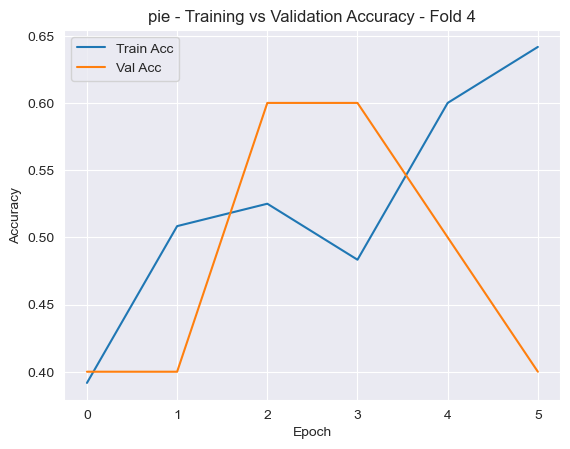

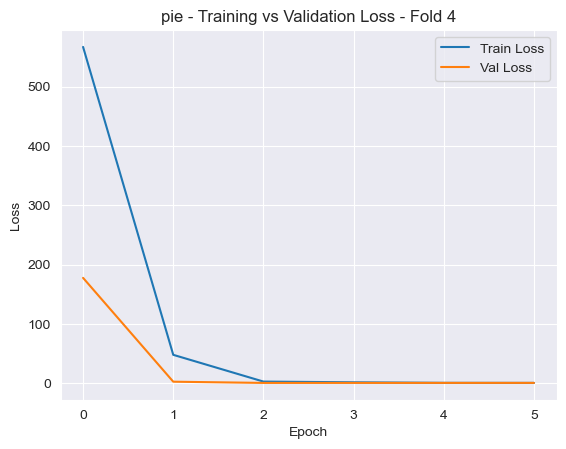

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


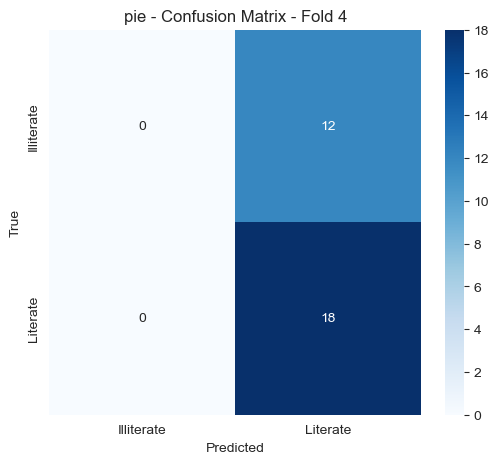

Fold 4 Final Train Acc: 0.6417, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.5415 - loss: 655.0823 - val_accuracy: 0.6000 - val_loss: 53.9979
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.5165 - loss: 125.1385 - val_accuracy: 0.6000 - val_loss: 14.3839
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3854 - loss: 39.7596 - val_accuracy: 0.5667 - val_loss: 0.6895
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5450 - loss: 0.7337 - val_accuracy: 0.6667 - val_loss: 0.6761
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6415 - loss: 0.6704 - val_accuracy: 0.4000 - val_loss: 1.1255
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6400 - loss: 0.6913 - val_accuracy: 0.6333 - val_loss: 0.6918
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy:

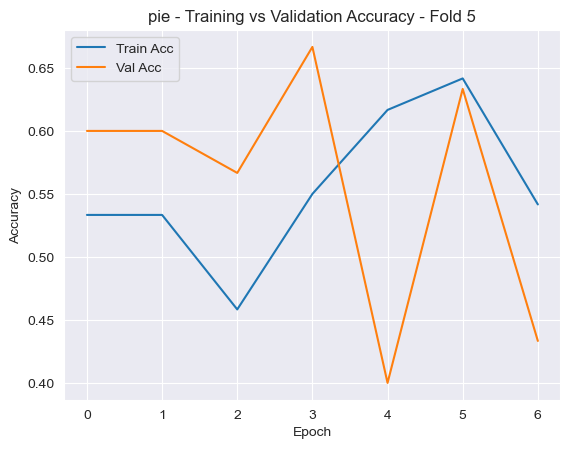

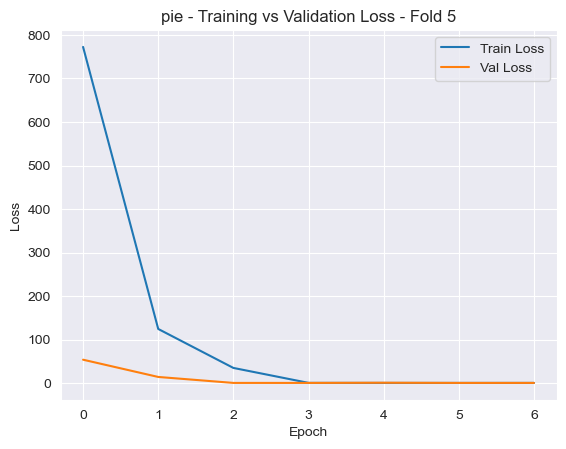

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


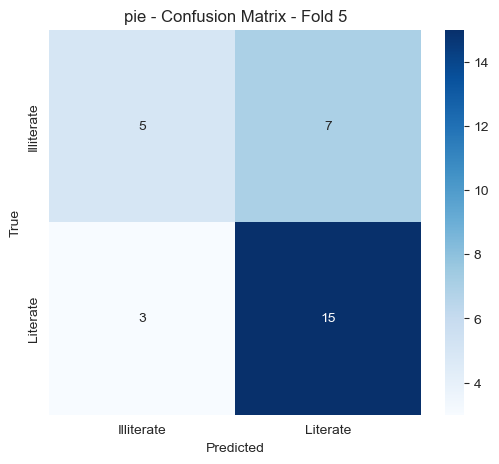

Fold 5 Final Train Acc: 0.5417, Final Val Acc: 0.4333


In [6]:
# Track results for all datasets
all_results = {}

# Perform training and collect fold-wise accuracies
for dataset_name in ["bar", "line", "pie"]:
    print(f"\n=== Running 5-fold CV for: {dataset_name} ===")
    average_results = {
        "train_accuracies": [],
        "val_accuracies": []
    }

    for fold in range(5):
        train_and_evaluate(dataset_name, fold, average_results)

    # Compute and store means
    all_results[dataset_name] = {
        "mean_train": np.mean(average_results["train_accuracies"]),
        "mean_val": np.mean(average_results["val_accuracies"])
    }

In [7]:
# Print summary after all training is done
print("\n=== Summary of Average Accuracies by Graph Type ===")
for dataset_name, result in all_results.items():
    print(f"\nGraph Type: {dataset_name}")
    print(f"→ Average Train Accuracy: {result['mean_train']:.4f}")
    print(f"→ Average Validation Accuracy: {result['mean_val']:.4f}")


=== Summary of Average Accuracies by Graph Type ===

Graph Type: bar
→ Average Train Accuracy: 0.5837
→ Average Validation Accuracy: 0.5510

Graph Type: line
→ Average Train Accuracy: 0.6596
→ Average Validation Accuracy: 0.6351

Graph Type: pie
→ Average Train Accuracy: 0.5517
→ Average Validation Accuracy: 0.4000
